# Buckling Plate Demo

# (User Need: Big Picture)

In [1]:
## Initialize the package
import grama as gr

### Buckling Plate

![Plate](./plate_free_sides.png)

(Peery, 1950)

### Implement Governing Equation

$$g_{\text{buckle}} = \frac{\pi^2 E}{12 (1 - \mu^2)}\left(\frac{t}{h}\right)^2 - \frac{L}{wt}$$

In [2]:
## Implement governing equation
pi = 3.14159

def g_buckle(x):
    t, w, h, E, mu, L = x
    
    return pi**2 * E / 12. / (1 - mu**2) * (t / h) ** 2 - L / (w * t)

var_list = ["t", "w", "h", "E", "mu", "L"]

### Study Data

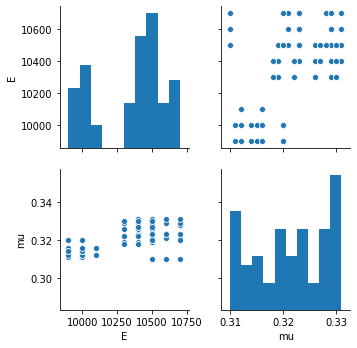

In [3]:
## Import data for the model
from grama.data import df_stang
## Import plotting tools
import seaborn as sns
## Plot the data
sns.pairplot(df_stang[["E", "mu"]]) # Elasticity and poisson ratio

### Build Model

In [4]:
## Build the model
md_plate = \
    gr.Model("Plate under buckling load") >> \
    gr.cp_function(
        fun=g_buckle,    # (above)
        var=var_list,    # (above)
        out=["g_buckle"] # Output name
    ) >> \
    gr.cp_bounds( # Deterministic variables
        t=(0.03, 0.12),    # Thickness
        w=(6, 18),         # Width
        h=(6, 18),         # Height
        L=(2.5e-1, 4.0e-1) # Load
    ) >> \
    gr.cp_marginals( # Random variables
        E=gr.marg_named(df_stang.E, "norm"),
        mu=gr.marg_named(df_stang.mu, "beta")
    ) >> \
    gr.cp_copula_gaussian(df_data=df_stang) # Dependence
    
md_plate.printpretty()

model: Plate under buckling load

  inputs:
    var_det:
      h: [6, 18]
      L: [0.25, 0.4]
      t: [0.03, 0.12]
      w: [6, 18]
    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 258.7392188662194}
      mu: (+0) beta, {'a': 1.0039017654316746, 'b': 0.8622680473775106, 'loc': 0.3094053248270583, 'scale': 0.021594675172941728}
    copula:
        Gaussian copula with correlations:
  var1 var2      corr
0   mu    E  0.371244
  functions:
    g_buckle: ['t', 'w', 'h', 'E', 'mu', 'L'] -> ['g_buckle']


### Analyze Model: Deterministic approach

In [5]:
df_conservative = \
    md_plate >> \
    gr.ev_conservative(df_det="nom")
df_conservative[["g_buckle"]]    

eval_conservative() using quantile default 0.01;
provide `quantiles` keyword for non-default behavior.


,g_buckle
0,0.009516


Limit state `g_buckle > 0` implies safe structure.

### Analyze Model Uncertainty

eval_monte_carlo() is rounding n...


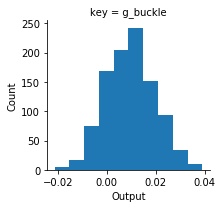

In [6]:
## Analyze the model
md_plate >> \
    gr.ev_monte_carlo(n=1e3, df_det="nom") >> \
    gr.pt_auto()

Uncertainty analysis reveals chance of failure.